In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#Esta celda es por problemas de compatibilidad con la GPU en la última actualización

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
df = pd.read_csv('datasets/hurto_a_persona.csv', sep=';')

e:\ProgramasInstalados\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


En vista de que pueden haber entradas duplicadas o NaN, se procede a eliminarlas

In [4]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [5]:
df.columns

Index(['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad',
       'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte',
       'nivel_academico', 'testigo', 'conducta', 'modalidad',
       'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal',
       'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna',
       'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien',
       'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion'],
      dtype='object')

Se eliminan las columnas 'grupo_actor', 'cantidad', 'actividad_delictiva', 'parentesco', 'discapacidad', 'grupo_especial', 'nivel_academico', 'testigo', 'conducta', 'caracterizacion', 'articulo_penal', 'categoria_penal', 'permiso', 'unidad_medida', debido a que no contienen datos.

In [6]:
df.drop(columns=['ocupacion', 'grupo_actor', 'cantidad', 'actividad_delictiva', 'parentesco', 'discapacidad', 'grupo_especial', 'nivel_academico', 'testigo', 'conducta', 'caracterizacion', 'articulo_penal', 'categoria_penal', 'permiso', 'unidad_medida'], inplace=True)

Ahora, se eliminan columnas que no proveen información de interés, como el estado civil, la sede receptora (pues no está en el foco considerar dónde se recibió), el bien hurtado, la categoría del bien, el grupo del bien, el modelo, el color y la fecha de ingestión (pues es el mismo dato en todas las entradas)

In [7]:
df.drop(columns=['estado_civil', 'sede_receptora', 'bien', 'categoria_bien', 'modelo', 'color', 'fecha_ingestion', 'conducta_especial', 'arma_medio'], inplace=True)

In [8]:
df.shape

(239402, 12)

Se eliminan las filas que contengan edades menores que cero y mayores que 100

In [9]:
filt = df[df['edad'] <= 0]
df.drop(filt.index, inplace=True)
filt = df[df['edad'] > 100]
df.drop(filt.index, inplace=True)

Se eliminan las filas sin dato 'sexo' 

In [10]:
filt = df[df['sexo'] == "Sin dato"]
df.drop(filt.index, inplace = True)

# Enfoque en el barrio El Poblado

Se va a enfocar este trabajo en el barrio "El Poblado", por lo que se crea un nuevo dataframe con únicamente la información de este barrio

In [11]:
filt = df[df['nombre_barrio']=='El Poblado']
df_poblado = filt
df_poblado = df_poblado.copy()

Ya filtrado, se eliminan las columnas 'latitud', 'longitud', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna'. Además, se definen los sexos en valores numéricos y se convierte el tipo de dato de la columna 'fecha_hecho' en datetime

In [12]:
# Replace sexo
# df_poblado['sexo'].replace({'Hombre':0, 'Mujer':1}, inplace=True)

# Convert date to proper datetime
df_poblado['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'], format="%Y-%m-%dT%X.000-05:00")

# Drop unnecessary columns
df_poblado.drop(columns=['latitud', 'longitud', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna'], inplace=True)

# Date range set [2016,2021]
filt = df_poblado[df_poblado['fecha_hecho'].dt.year > 2021]
df_poblado.drop(filt.index, inplace=True)
filt = df_poblado[df_poblado['fecha_hecho'].dt.year < 2015]
df_poblado.drop(filt.index, inplace=True)

del filt

# Set 'fecha_hecho' as dataframe index
df_poblado.set_index('fecha_hecho', inplace=True)

# Ordenar dataset por fecha
df_poblado.sort_index(inplace=True)

In [13]:
df_poblado.head()

,sexo,edad,medio_transporte,modalidad,lugar,grupo_bien
fecha_hecho,,,,,,
2015-01-03 00:00:00,Hombre,22,Caminata,Descuido,Oficina,Mercancía
2015-01-16 22:00:00,Hombre,23,Caminata,Raponazo,Parque,Mercancía
2015-01-16 22:00:00,Hombre,23,Caminata,Raponazo,Parque,Mercancía
2015-01-20 08:30:00,Mujer,25,Caminata,Descuido,"Hotel, motel y hostal",Mercancía
2015-01-20 08:30:00,Mujer,25,Caminata,Descuido,"Hotel, motel y hostal",Mercancía


In [14]:
df_poblado['sexo'].value_counts()

Hombre    2559
Mujer     1764
Name: sexo, dtype: int64

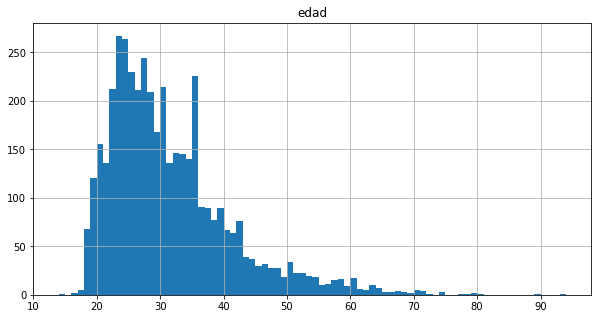

In [15]:
df_poblado.hist(['edad'], figsize=(10,5), bins=80);

# Análisis de la variable 'Sexo'

In [16]:
# df_freq = pd.crosstab(df_poblado.index.date, [df_poblado['sexo'],df_poblado['grupo_bien']], rownames=['fecha_hecho'], colnames=['Sexo', 'Grupo_Bien'])
df_freq = pd.crosstab(df_poblado.index.date, df_poblado['sexo'], rownames=['Fecha_Hecho'], colnames=['Sexo'])
df_freq.index = pd.to_datetime(df_freq.index)

In [17]:
from ipywidgets import interact

@interact(Sexo = ['Hombre', 'Mujer'], Ambos = False)

def plotSomething(Sexo, Ambos):
    plt.figure(figsize=[25,8])
    if(Ambos):
        plt.plot(df_freq.index, df_freq['Hombre'], label='Hombre')
        plt.plot(df_freq.index, df_freq['Mujer'], label='Mujer')
    else:
        plt.plot(df_freq.index, df_freq[Sexo], label=Sexo)
    plt.legend(loc='best')
    plt.xlabel('Año')
    plt.ylabel('Número de eventos')
    plt.title('Frecuencia de hurtos según sexo')

interactive(children=(Dropdown(description='Sexo', options=('Hombre', 'Mujer'), value='Hombre'), Checkbox(valu…

# Tratando el subconjunto de Hombres

In [18]:
# Datos de hombres hasta 2020 para entrenamiento
df_male_train = df_freq[:'2019'].iloc[:,0].values

# Datos de hombres hasta 2020 para prueba
df_male_test = df_freq['2020':].iloc[:,0].values

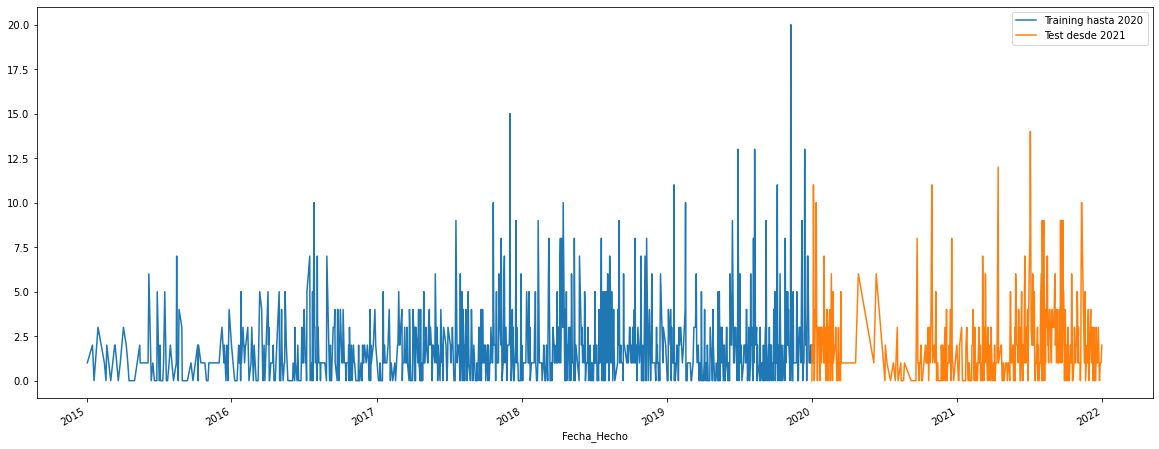

In [19]:
df_freq['Hombre'][:'2019'].plot(figsize=(20,8), legend=True)
df_freq['Hombre']['2020':].plot(figsize=(20,8), legend=True)
plt.legend(['Training hasta 2020', 'Test desde 2021'])
plt.show()

In [20]:
df_male_train = df_male_train.reshape(-1,1)
# Normalización de los datos de entrenamiento para 'Hombre'
Scale = MinMaxScaler(feature_range=(0,1))
df_male_train_scaled = Scale.fit_transform(df_male_train)

In [21]:
# Función para constuir un dataset x,y
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [22]:
look_back = 10
x_male_train, y_male_train = create_dataset(df_male_train_scaled, look_back)
print(x_male_train.shape)
print(y_male_train.shape)

(914, 10)
(914,)


In [23]:
# Arquitectura del modelo
model = Sequential()
model.add(LSTM(units=50, input_shape=(x_male_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(Dense(units=1))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compilación del modelo LSTM
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(x_male_train.reshape(x_male_train.shape[0],look_back,1),y_male_train,epochs=50,batch_size=16, verbose=1)

Epoch 1/50
58/58 [==============================] - 2s 4ms/step - loss: 0.0134
Epoch 2/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 4/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 5/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 6/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 8/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 9/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 10/50
58/58 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 11/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 12/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 13/50
58/58 [==============================

In [26]:
dataset_total = pd.concat((df_freq["Hombre"][:'2020'],df_freq["Mujer"]['2021':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(df_male_test) - look_back:].values
inputs = dataset_total[len(dataset_total)-len(df_male_test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = Scale.transform(inputs)
inputs.shape

(407, 1)

In [27]:
# Preparación de X_test
X_male_test = []
for i in range(look_back,inputs.shape[0]):
    X_male_test.append(inputs[i-look_back:i,0])
X_male_test = np.array(X_male_test)
X_male_test = np.reshape(X_male_test, (X_male_test.shape[0],X_male_test.shape[1],1))

In [28]:
# Predicciones obtenidas
predicted_mugging = model.predict(X_male_test)
predicted_mugging = Scale.inverse_transform(predicted_mugging)

13/13 [==============================] - 0s 1ms/step


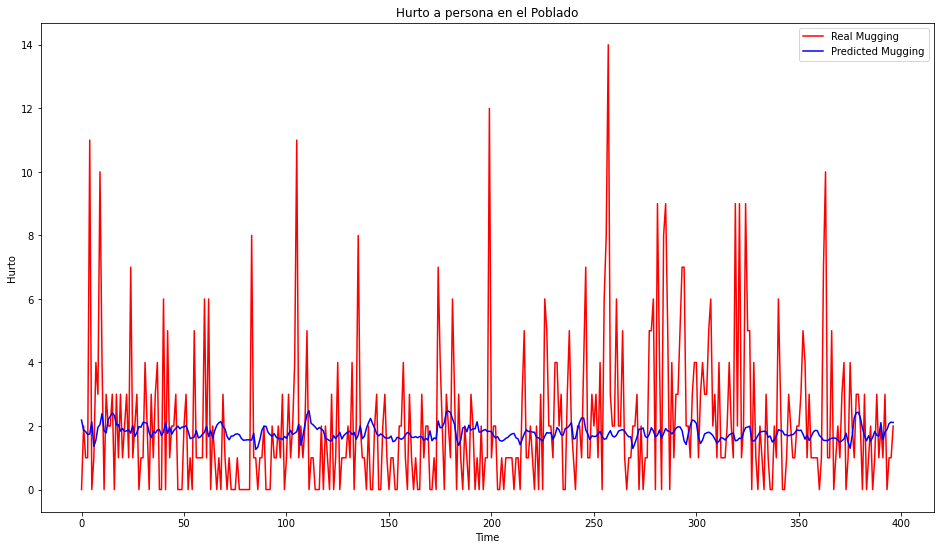

In [29]:
# Gráfico de resultados
plt.figure(figsize=(16,9))
plt.plot(df_male_test, color='red',label='Real Mugging')
plt.plot(predicted_mugging, color='blue',label='Predicted Mugging')
plt.title('Hurto a persona en el Poblado')
plt.xlabel('Time')
plt.ylabel('Hurto')
plt.legend()
plt.show()

In [30]:
# Evaluación del modelo mediante RMSE
rmse = math.sqrt(mean_squared_error(df_male_test, predicted_mugging))
print("El error de raíz cuadrática media es {}.".format(rmse))

El error de raíz cuadrática media es 2.270759086740418.
